In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.datasets import StructuredDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from IPython.display import Markdown, display

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping


import keras_uncertainty as ku
import keras_uncertainty.backend as K

from keras_uncertainty.layers import StochasticDropout
from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense, SamplingSoftmax
from keras_uncertainty.utils import numpy_entropy


`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

### LOADING DATASET FROM AIF360

Currently we are working with "Adult Dataset" in this notebook. The following code loads the dataset from AIF360. The dataset is already split into train and test sets. We will use the train set to train our models and the test set to evaluate the models.

In [2]:
# load dataset
dataset_orig = load_preproc_data_adult()

# split into train and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.80], shuffle=True)

# priveleged and unpriveleged groups
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(dataset_orig_test.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Priveleged and unpriveleged groups"))
print(privileged_groups, unprivileged_groups)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(39073, 18)


#### Test Dataset shape

(9769, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Priveleged and unpriveleged groups

[{'sex': 1}] [{'sex': 0}]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [3]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.193792
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.197459


In [4]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [5]:
# produce 5 shuffled train test groups of the original dataset (A-E)

train_A, test_A = dataset_orig.split([0.8], shuffle=True)
# train_B, test_B = dataset_orig.split([0.8], shuffle=True)
# train_C, test_C = dataset_orig.split([0.8], shuffle=True)
# train_D, test_D = dataset_orig.split([0.8], shuffle=True)
# train_E, test_E = dataset_orig.split([0.8], shuffle=True)

groups = ['A'] #, 'B', 'C', 'D', 'E']
# 0.1 to 1.0 with interval of 0.1 and round to 1 decimal places
pruned_percentages = np.round(np.linspace(0.1, 1.0, 10), 1)

# prepare all possible train groups for each A-E with different pruning percentages (60-100%)
train_groups = {}
for group in groups:
    train_groups[group] = {}
    for percentage in pruned_percentages:
        train_groups[group][percentage] = eval('train_{}'.format(group)).copy()
        train_groups[group][percentage].features = train_groups[group][percentage].features[:int(len(train_groups[group][percentage].features) * percentage)]
        train_groups[group][percentage].labels = train_groups[group][percentage].labels[:int(len(train_groups[group][percentage].labels) * percentage)]
        

In [7]:
#print the shape of each train group A
for i in range(10):
    print("Train group A features shape for pruning percentage", pruned_percentages[i]*100, ":\t", train_groups['A'][pruned_percentages[i]].features.shape)
    print("Train group A labels shape for pruning percentage", pruned_percentages[i]*100, ":\t", train_groups['A'][pruned_percentages[i]].labels.shape)

Train group A features shape for pruning percentage 10.0 :	 (3907, 18)
Train group A labels shape for pruning percentage 10.0 :	 (3907, 1)
Train group A features shape for pruning percentage 20.0 :	 (7814, 18)
Train group A labels shape for pruning percentage 20.0 :	 (7814, 1)
Train group A features shape for pruning percentage 30.0 :	 (11721, 18)
Train group A labels shape for pruning percentage 30.0 :	 (11721, 1)
Train group A features shape for pruning percentage 40.0 :	 (15629, 18)
Train group A labels shape for pruning percentage 40.0 :	 (15629, 1)
Train group A features shape for pruning percentage 50.0 :	 (19536, 18)
Train group A labels shape for pruning percentage 50.0 :	 (19536, 1)
Train group A features shape for pruning percentage 60.0 :	 (23443, 18)
Train group A labels shape for pruning percentage 60.0 :	 (23443, 1)
Train group A features shape for pruning percentage 70.0 :	 (27351, 18)
Train group A labels shape for pruning percentage 70.0 :	 (27351, 1)
Train group A fea

The above files are now stored as .pkl files in the directory. Use these files directly for running model tests.

In [8]:
# save the train_groups to a file
import pickle
with open('Experiment 2/train_groups.pkl', 'wb') as f:
    pickle.dump(train_groups, f)

# save the test to a file
with open('Experiment 2/test.pkl', 'wb') as f:
    pickle.dump(test_A, f)


### LOADING FROM FILE

In [9]:
#load from file
import pickle
with open('Experiment 2/train_groups.pkl', 'rb') as f:
    train_groups = pickle.load(f)

with open('Experiment 2/test.pkl', 'rb') as f:
    test_A = pickle.load(f)

### Prepare Model Functions for training
#### Creating statistical classes and functions for uncertainty disentanglement

In [10]:
class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=1, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=batch_size, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)

class StochasticClassifier(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)

    def predict(self, inp, num_samples=None, batch_size=32, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        mean_probs = np.mean(samples, axis=0)
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)

        return mean_probs

class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)

    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return mean_pred, std_pred    

class TwoHeadStochasticRegressor(StochasticModel):
    """
        A stochastic model that has two ouput heads, one for mean and another for variance, useful for aleatoric/epistemic uncertainty estimation.
    """
    def __init__(self, model, num_samples=10, variance_type="linear_variance"):
        super().__init__(model, num_samples)

        assert variance_type in ["logit", "linear_std", "linear_variance"]
        self.variance_type = variance_type

    """
        Preprocesses and interprets the variance output prodcued by the model, producing a standard deviation.
    """
    def preprocess_variance_output(self, var_input):
        if self.variance_type is "logit":
            return np.exp(var_input)

        if self.variance_type is "linear_variance":
            return np.sqrt(var_input)
        
        return var_input

    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, disentangle_uncertainty=False, **kwargs):
        """
            Performs a prediction given input inp and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, multi_output=True, **kwargs)
        mean_samples, var_samples = [x[0] for x in samples], [x[1] for x in samples]

        if output_scaler is not None:
            mean_samples = list(map(lambda x: output_scaler.inverse_transform(x), mean_samples))
            var_samples = list(map(lambda x: output_scaler.inverse_transform(x), var_samples))

        means = np.array(mean_samples)
        variances = np.array(var_samples)
        stds = self.preprocess_variance_output(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(np.square(stds) + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
        mixture_std = np.sqrt(mixture_var)
                                
        if disentangle_uncertainty:            
            epi_std = np.std(means, axis=0)
            ale_std = np.mean(stds, axis=0)

            return mixture_mean, ale_std, epi_std

        return mixture_mean, mixture_std

class KernelDensityStochasticModel(StochasticModel):
    def __init__(self, model, num_samples=10, bandwidth=1.0):
        super().__init__(model, num_samples)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)

    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

def sampling_softmax(mean_logit, std_logit, num_samples=10):
    logit_shape = (mean_logit.shape[0], num_samples, mean_logit.shape[-1])

    logit_mean = np.expand_dims(mean_logit, axis=1)
    logit_mean = np.repeat(logit_mean, num_samples, axis=1)

    logit_std = np.expand_dims(std_logit, axis=1)
    logit_std = np.repeat(logit_std, num_samples, axis=1)

    logit_samples = np.random.normal(size=logit_shape, loc=logit_mean, scale=logit_std)

    prob_samples = softmax(logit_samples, axis=-1)
    probs = np.mean(prob_samples, axis=1)

    # This is required due to approximation error, without it probabilities can sum to 1.01 or 0.99
    probs = probs / np.sum(probs, axis=-1, keepdims=True) 

    return probs

class DisentangledStochasticClassifier(TwoHeadStochasticRegressor):
    def __init__(self, model, epi_num_samples=10, ale_num_samples=100) -> None:
        super(DisentangledStochasticClassifier, self).__init__(model, num_samples=epi_num_samples)

        self.epi_num_samples = epi_num_samples
        self.ale_num_samples = ale_num_samples

    def predict(self, inp, num_samples=None, batch_size=32):
        y_logits_mean, y_logits_std_ale, y_logits_std_epi = TwoHeadStochasticRegressor.predict(self, inp, num_samples=num_samples, batch_size=batch_size, disentangle_uncertainty=True)

        y_probs = sampling_softmax(y_logits_mean, y_logits_std_ale + y_logits_std_epi, num_samples=self.ale_num_samples)
        y_probs_epi = sampling_softmax(y_logits_mean, y_logits_std_epi, num_samples=self.ale_num_samples)
        y_probs_ale = sampling_softmax(y_logits_mean, y_logits_std_ale, num_samples=self.ale_num_samples)

        return y_probs, y_probs_ale, y_probs_epi



<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Zohair Hashmi\AppData\Local\Temp\ipykernel_8548\1140481961.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.variance_type is "logit":
C:\Users\Zohair Hashmi\AppData\Local\Temp\ipykernel_8548\1140481961.py:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.variance_type is "linear_variance":


#### Neural Network Models for quantifying uncertainty

In [11]:
def uncertainty(probs):
    return numpy_entropy(probs, axis=-1)

def two_head_model(trunk_model, num_classes=2, num_samples=100):
    inp = Input(shape=(18,))
    x = trunk_model(inp)
    logit_mean = Dense(num_classes, activation="linear")(x)
    logit_var = Dense(num_classes, activation="softplus")(x)
    probs = SamplingSoftmax(num_samples=num_samples, variance_type="linear_std")([logit_mean, logit_var])
    
    train_model = Model(inp, probs, name="train_model")
    pred_model = Model(inp, [logit_mean, logit_var], name="pred_model")

    train_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return train_model, pred_model

def train_eval_stochastic_model(trunk_model, x_train, y_train, domain, epochs=300):
    train_model, pred_model = two_head_model(trunk_model)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    train_model.fit(x_train, y_train, verbose=2, epochs=epochs, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[es])

    fin_model = DisentangledStochasticClassifier(pred_model, epi_num_samples=NUM_SAMPLES)
    print("predicting...")
    pred_mean, pred_ale_std, pred_epi_std = fin_model.predict(domain, batch_size=BATCH_SIZE)
    print("prediction completed")
    ale_entropy = uncertainty(pred_ale_std)
    epi_entropy = uncertainty(pred_epi_std)

    return ale_entropy, epi_entropy

def train_dropout_model(x_train, y_train, domain, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
    model.add(StochasticDropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(StochasticDropout(prob))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)

def train_ensemble_model(x_train, y_train, domain, ensemble_size=10):
    models = []
    for i in range(ensemble_size):
        model = Sequential()
        model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(2, activation="linear"))

        model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      metrics=[tf.keras.metrics.BinaryAccuracy(),
                               tf.keras.metrics.FalseNegatives()])

        models.append(model)

    ale_entropy = 0
    epi_entropy = 0
    i = 0

    for model in models:
        ale, epi = train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)
        ale_entropy += ale
        epi_entropy += epi
        print('ensemble model ', i + 1, ' trained')
        i += 1

    ale_entropy /= ensemble_size
    epi_entropy /= ensemble_size

    return ale_entropy, epi_entropy

def train_dropout_ensemble_model(x_train, y_train, domain, prob=0.5, ensemble_size=10):
    models = []
    for i in range(ensemble_size):
        model = Sequential()
        model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
        model.add(StochasticDropout(prob))
        model.add(Dense(32, activation="relu"))
        model.add(StochasticDropout(prob))

        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        models.append(model)

    ale_entropy = 0
    epi_entropy = 0
    i = 0

    for model in models:
        ale, epi = train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)
        ale_entropy += ale
        epi_entropy += epi
        print('ensemble model ', i + 1, ' trained')
        i += 1

    ale_entropy /= ensemble_size
    epi_entropy /= ensemble_size

    return ale_entropy, epi_entropy
        
NUM_SAMPLES = 50
BATCH_SIZE = 256

In [12]:
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
pruned_percentages

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

### ENSEMBLE MODEL

In [14]:
train_groups['A'][pruned_percentages[0]].features.shape ,train_groups['A'][pruned_percentages[0]].labels.ravel().shape

((3907, 18), (3907,))

In [15]:
# train ensemble model for prune percentage 0.1 to 1.0

ale_entropy_ensemble = []
epi_entropy_ensemble = []


for i in range(0, 10):
    print('prune percentage: ', np.round((i * 0.1 + 0.1),1))
    ale_entropy, epi_entropy = train_ensemble_model(train_groups['A'][pruned_percentages[i]].features, train_groups['A'][pruned_percentages[i]].labels.ravel(), test_A.features, ensemble_size=10)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    ale_entropy_ensemble.append(ale_entropy)
    epi_entropy_ensemble.append(epi_entropy)

    print('')


prune percentage:  0.1
Epoch 1/100


C:\Users\ZOHAIR~1\AppData\Local\Temp\__autograph_generated_filebd_m_wqw.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(self).variance_type is 'linear_variance', if_body, else_body, get_state, set_state, ('do_return', 'retval_'), 2)
C:\Users\ZOHAIR~1\AppData\Local\Temp\__autograph_generated_filebd_m_wqw.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(self).variance_type is 'logit', if_body_1, else_body_1, get_state_1, set_state_1, ('do_return', 'retval_'), 2)


13/13 - 2s - loss: 0.9809 - accuracy: 0.5642 - val_loss: 0.9256 - val_accuracy: 0.7340 - 2s/epoch - 174ms/step
Epoch 2/100
13/13 - 0s - loss: 0.8943 - accuracy: 0.7488 - val_loss: 0.8498 - val_accuracy: 0.7494 - 118ms/epoch - 9ms/step
Epoch 3/100
13/13 - 0s - loss: 0.8211 - accuracy: 0.7555 - val_loss: 0.7923 - val_accuracy: 0.7506 - 119ms/epoch - 9ms/step
Epoch 4/100
13/13 - 0s - loss: 0.7659 - accuracy: 0.7555 - val_loss: 0.7504 - val_accuracy: 0.7506 - 112ms/epoch - 9ms/step
Epoch 5/100
13/13 - 0s - loss: 0.7221 - accuracy: 0.7555 - val_loss: 0.7126 - val_accuracy: 0.7506 - 163ms/epoch - 13ms/step
Epoch 6/100
13/13 - 0s - loss: 0.6835 - accuracy: 0.7555 - val_loss: 0.6809 - val_accuracy: 0.7506 - 140ms/epoch - 11ms/step
Epoch 7/100
13/13 - 0s - loss: 0.6496 - accuracy: 0.7555 - val_loss: 0.6535 - val_accuracy: 0.7506 - 113ms/epoch - 9ms/step
Epoch 8/100
13/13 - 0s - loss: 0.6193 - accuracy: 0.7555 - val_loss: 0.6260 - val_accuracy: 0.7506 - 94ms/epoch - 7ms/step
Epoch 9/100
13/13 - 

In [16]:
#mean of each entropy in epi_entropy_ensemble
for i in range(0, 10):
    print('prune percentage: ', np.round((i * 0.1 + 0.1),1))
    print('ale entropy: ', np.mean(ale_entropy_ensemble[i]))
    print('epi entropy: ', np.mean(epi_entropy_ensemble[i]))
    print('')



prune percentage:  0.1
ale entropy:  0.4331006538005681
epi entropy:  0.39990543133480355

prune percentage:  0.2
ale entropy:  0.4422695844261612
epi entropy:  0.40993208989367735

prune percentage:  0.3
ale entropy:  0.43212319298965857
epi entropy:  0.40251404333295054

prune percentage:  0.4
ale entropy:  0.4367322031761496
epi entropy:  0.408244231938987

prune percentage:  0.5
ale entropy:  0.4347652974907427
epi entropy:  0.4061456993476565

prune percentage:  0.6
ale entropy:  0.4467191935425547
epi entropy:  0.4194766174981055

prune percentage:  0.7
ale entropy:  0.43342684828343114
epi entropy:  0.40847373683046306

prune percentage:  0.8
ale entropy:  0.4319309943535095
epi entropy:  0.410799743624939

prune percentage:  0.9
ale entropy:  0.43312235243810837
epi entropy:  0.41136727883947

prune percentage:  1.0
ale entropy:  0.44150026120695235
epi entropy:  0.41741043519794147



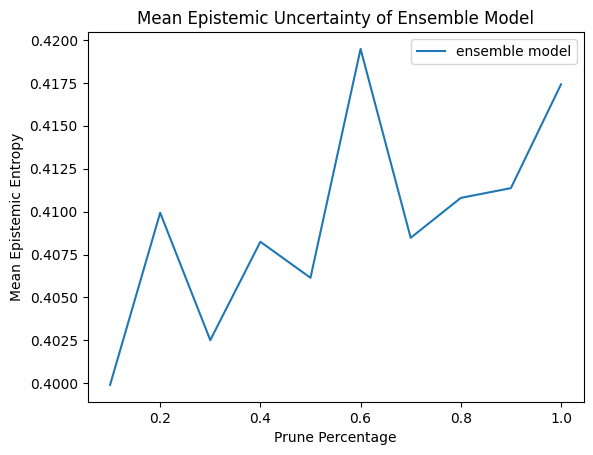

In [17]:
import matplotlib.pyplot as plt

# sketch graph for mean epistemic entropy of ensemble model
plt.plot(pruned_percentages, np.mean(epi_entropy_ensemble, axis=1), label='ensemble model')
plt.xlabel('DataSet size') # earlie named prune percentage but is actually a dataset size
plt.ylabel('Mean Epistemic Entropy')
plt.title('Mean Epistemic Uncertainty of Ensemble Model')
plt.legend()
plt.show()


In [18]:
#ale_entropy_ensemble to dict
ale_entropy_ensemble_dict = {}
for i in range(0, 10):
    ale_entropy_ensemble_dict[pruned_percentages[i]] = ale_entropy_ensemble[i]
    
#epi_entropy_ensemble to dict
epi_entropy_ensemble_dict = {}
for i in range(0, 10):
    epi_entropy_ensemble_dict[pruned_percentages[i]] = epi_entropy_ensemble[i]

# #save to pickle file
# import pickle

# with open('Experiment 2/ale_entropy_ensemble_dict.pickle', 'wb') as handle:
#     pickle.dump(ale_entropy_ensemble_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('Experiment 2/epi_entropy_ensemble_dict.pickle', 'wb') as handle:
#     pickle.dump(epi_entropy_ensemble_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# #load pickle file
# import pickle

# with open('Experiment 2/ale_entropy_ensemble_dict.pickle', 'rb') as handle:
#     ale_entropy_ensemble_dict = pickle.load(handle)

# with open('Experiment 2/epi_entropy_ensemble_dict.pickle', 'rb') as handle:
#     epi_entropy_ensemble_dict = pickle.load(handle)


### DROP OUT MODEL

In [20]:
# train dropout model for prune percentage 0.1 to 1.0

ale_entropy_dropout = []
epi_entropy_dropout = []

for i in range(0, 10):
    print('prune percentage: ', np.round((i * 0.1 + 0.1),1))
    ale_entropy, epi_entropy = train_dropout_model(train_groups['A'][pruned_percentages[i]].features, train_groups['A'][pruned_percentages[i]].labels.ravel(), test_A.features, prob=0.5)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    ale_entropy_dropout.append(ale_entropy)
    epi_entropy_dropout.append(epi_entropy)

    print('')

prune percentage:  0.1
Epoch 1/100
13/13 - 1s - loss: 0.6566 - accuracy: 0.6006 - val_loss: 0.6306 - val_accuracy: 0.6573 - 1s/epoch - 110ms/step
Epoch 2/100
13/13 - 0s - loss: 0.6066 - accuracy: 0.7110 - val_loss: 0.5915 - val_accuracy: 0.7327 - 101ms/epoch - 8ms/step
Epoch 3/100
13/13 - 0s - loss: 0.5756 - accuracy: 0.7418 - val_loss: 0.5726 - val_accuracy: 0.7468 - 164ms/epoch - 13ms/step
Epoch 4/100
13/13 - 0s - loss: 0.5549 - accuracy: 0.7485 - val_loss: 0.5578 - val_accuracy: 0.7519 - 98ms/epoch - 8ms/step
Epoch 5/100
13/13 - 0s - loss: 0.5435 - accuracy: 0.7552 - val_loss: 0.5449 - val_accuracy: 0.7481 - 106ms/epoch - 8ms/step
Epoch 6/100
13/13 - 0s - loss: 0.5255 - accuracy: 0.7558 - val_loss: 0.5468 - val_accuracy: 0.7519 - 99ms/epoch - 8ms/step
Epoch 7/100
13/13 - 0s - loss: 0.5153 - accuracy: 0.7606 - val_loss: 0.5416 - val_accuracy: 0.7532 - 99ms/epoch - 8ms/step
Epoch 8/100
13/13 - 0s - loss: 0.5123 - accuracy: 0.7546 - val_loss: 0.5305 - val_accuracy: 0.7417 - 113ms/epoch

In [21]:
#mean of each entropy in ale and epi_entropy_dropout
for i in range(0, 10):
    print('prune percentage: ', np.round((i * 0.1 + 0.1),1))
    print('ale entropy: ', np.mean(ale_entropy_dropout[i]))
    print('epi entropy: ', np.mean(epi_entropy_dropout[i]))
    print('')
    

prune percentage:  0.1
ale entropy:  0.4454552318582524
epi entropy:  0.45708265520119934

prune percentage:  0.2
ale entropy:  0.41136622660451994
epi entropy:  0.40952486474073646

prune percentage:  0.3
ale entropy:  0.38495730761473357
epi entropy:  0.36717366083953473

prune percentage:  0.4
ale entropy:  0.4037653035643731
epi entropy:  0.39386542701177657

prune percentage:  0.5
ale entropy:  0.3947248894559907
epi entropy:  0.39086623140832116

prune percentage:  0.6
ale entropy:  0.37299320427687654
epi entropy:  0.36120543528867155

prune percentage:  0.7
ale entropy:  0.362206074087144
epi entropy:  0.3455606634832512

prune percentage:  0.8
ale entropy:  0.369617429275023
epi entropy:  0.3352512481648807

prune percentage:  0.9
ale entropy:  0.38393926805910383
epi entropy:  0.3429707033765465

prune percentage:  1.0
ale entropy:  0.37407844438648485
epi entropy:  0.3663111177106664



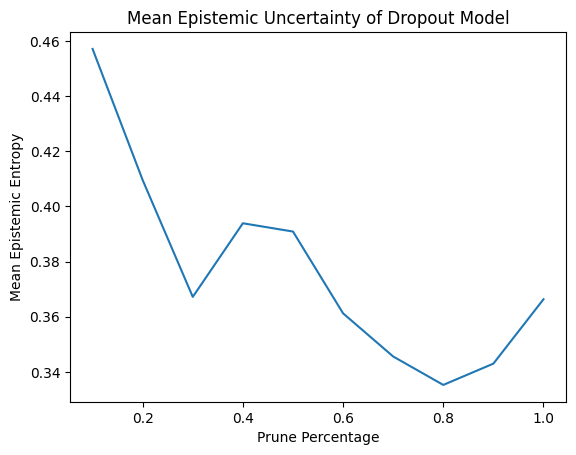

In [22]:
import matplotlib.pyplot as plt

#sketch graph of mean epistemic entropy for dropout model
plt.plot(pruned_percentages, [np.mean(epi_entropy_dropout[i]) for i in range(0, 10)])
plt.xlabel('DataSet size') # earlie named prune percentage but is actually a dataset size
plt.ylabel('Mean Epistemic Entropy')
plt.title('Mean Epistemic Uncertainty of Dropout Model')
plt.show()



In [23]:
#ale_entropy_dropout to dict
ale_entropy_dropout_dict = {}
for i in range(0, 10):
    ale_entropy_dropout_dict[pruned_percentages[i]] = ale_entropy_dropout[i]

#epi_entropy_dropout to dict
epi_entropy_dropout_dict = {}
for i in range(0, 10):
    epi_entropy_dropout_dict[pruned_percentages[i]] = epi_entropy_dropout[i]
    
# #save to pickle file
# import pickle

# with open('Experiment 2/ale_entropy_dropout_dict.pickle', 'wb') as handle:
#     pickle.dump(ale_entropy_dropout_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('Experiment 2/epi_entropy_dropout_dict.pickle', 'wb') as handle:
#     pickle.dump(epi_entropy_dropout_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


### ENSEMBLE DROP OUT MODEL

In [24]:
# train ensemble dropout model for prune percentage 0.1 to 1.0

ale_entropy_ensemble_dropout = []
epi_entropy_ensemble_dropout = []

for i in range(0, 10):
    print('prune percentage: ', np.round((i * 0.1 + 0.1),1))
    ale_entropy, epi_entropy = train_dropout_ensemble_model(train_groups['A'][pruned_percentages[i]].features, train_groups['A'][pruned_percentages[i]].labels.ravel(), test_A.features, ensemble_size=10, prob=0.5)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    ale_entropy_ensemble_dropout.append(ale_entropy)
    epi_entropy_ensemble_dropout.append(epi_entropy)

    print('')


prune percentage:  0.1
Epoch 1/100
13/13 - 1s - loss: 0.6368 - accuracy: 0.6598 - val_loss: 0.6122 - val_accuracy: 0.6982 - 1s/epoch - 82ms/step
Epoch 2/100
13/13 - 0s - loss: 0.5880 - accuracy: 0.7261 - val_loss: 0.5627 - val_accuracy: 0.7417 - 101ms/epoch - 8ms/step
Epoch 3/100
13/13 - 0s - loss: 0.5554 - accuracy: 0.7507 - val_loss: 0.5529 - val_accuracy: 0.7506 - 103ms/epoch - 8ms/step
Epoch 4/100
13/13 - 0s - loss: 0.5332 - accuracy: 0.7514 - val_loss: 0.5427 - val_accuracy: 0.7442 - 100ms/epoch - 8ms/step
Epoch 5/100
13/13 - 0s - loss: 0.5254 - accuracy: 0.7587 - val_loss: 0.5260 - val_accuracy: 0.7519 - 98ms/epoch - 8ms/step
Epoch 6/100
13/13 - 0s - loss: 0.5062 - accuracy: 0.7606 - val_loss: 0.5298 - val_accuracy: 0.7506 - 94ms/epoch - 7ms/step
Epoch 7/100
13/13 - 0s - loss: 0.4971 - accuracy: 0.7610 - val_loss: 0.5093 - val_accuracy: 0.7647 - 99ms/epoch - 8ms/step
Epoch 8/100
13/13 - 0s - loss: 0.4814 - accuracy: 0.7690 - val_loss: 0.5061 - val_accuracy: 0.7570 - 108ms/epoch -

In [25]:
#mean of each entropy in ale and epi_entropy_ensemble_dropout
for i in range(0, 10):
    print('prune percentage: ', np.round((i * 0.1 + 0.1),1))
    print('ale entropy: ', np.mean(ale_entropy_ensemble_dropout[i]))
    print('epi entropy: ', np.mean(epi_entropy_ensemble_dropout[i]))
    print('')

prune percentage:  0.1
ale entropy:  0.41853529229649605
epi entropy:  0.40501236415132985

prune percentage:  0.2
ale entropy:  0.4070361423064474
epi entropy:  0.39676728042218673

prune percentage:  0.3
ale entropy:  0.3922625012260232
epi entropy:  0.3788646130496312

prune percentage:  0.4
ale entropy:  0.3811426445584432
epi entropy:  0.36484434407107225

prune percentage:  0.5
ale entropy:  0.3919746452411798
epi entropy:  0.38155902703930744

prune percentage:  0.6
ale entropy:  0.387064989464386
epi entropy:  0.3699656830006126

prune percentage:  0.7
ale entropy:  0.377502426210156
epi entropy:  0.36115334615678063

prune percentage:  0.8
ale entropy:  0.38370200765037665
epi entropy:  0.3675695516834668

prune percentage:  0.9
ale entropy:  0.37799930591299896
epi entropy:  0.3513425925777833

prune percentage:  1.0
ale entropy:  0.3880226966302958
epi entropy:  0.3718098995714686



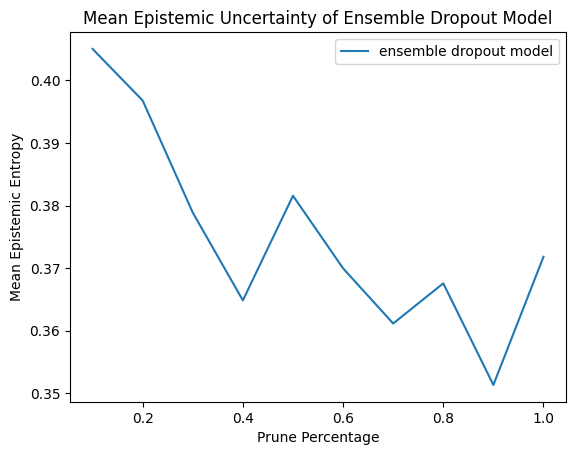

In [26]:
# sketch graph for mean epistemic entropy of ensemble dropout model
plt.plot(pruned_percentages, np.mean(epi_entropy_ensemble_dropout, axis=1), label='ensemble dropout model')
plt.xlabel('DataSet size') # earlie named prune percentage but is actually a dataset size
plt.ylabel('Mean Epistemic Entropy')
plt.title('Mean Epistemic Uncertainty of Ensemble Dropout Model')
plt.legend()
plt.show()


In [27]:
# #save to pickle file
# import pickle

# with open('Experiment 2/ale_entropy_ensemble_dropout_dict.pickle', 'wb') as handle:
#     pickle.dump(ale_entropy_ensemble_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('Experiment 2/epi_entropy_ensemble_dropout_dict.pickle', 'wb') as handle:
#     pickle.dump(epi_entropy_ensemble_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)

# #load pickle file
# import pickle

# with open('Experiment 2/ale_entropy_ensemble_dropout_dict.pickle', 'rb') as handle:
#     ale_entropy_ensemble_dropout = pickle.load(handle)

# with open('Experiment 2/epi_entropy_ensemble_dropout_dict.pickle', 'rb') as handle:
#     epi_entropy_ensemble_dropout = pickle.load(handle)
